In [40]:
# -*- coding: utf-8 -*-
import random
import numpy as np
import tensorflow as tf
import collections
import math
from six.moves import xrange
from konlpy.tag import Twitter
from six.moves import xrange

class Word2Vec:
    # 데이터 에서 대화만 가져오기 
    def load_file(self,filesrc):
        f = open(filesrc, 'rt', encoding='utf-16')
        name = ""
        talk = []
        speak = {}
        not_person = ['al', 'ot']
        talk_all = []
        while(True):
            data = f.readline() 
            if not data: break
    
            if("<u who=" in data or "<s n=" in data):
                # 발화자 구분
                if "who" in data:
                    name = data[8:10]
                    if name in not_person:
                        continue
                    if not (name in speak):
                       speak[name] = [] 
    
                # 대화 추출
                temp = data.split(">")
                s = ""
                for v in temp:
                    idx = v.find('<')
                    if idx < 2: continue
                    speak[name].append(v[:idx])
                    talk_all.append(v[:idx])
    
        return speak,talk_all

    
    def words_join(self,words,doc_index):
        word_idx = []
        doc_count = 0
        for index,lines in enumerate(words):
            if len(doc_index) > doc_count and index >= doc_index[doc_count]:
                doc_count += 1
            word_idx += [[v,index,doc_count] for v in lines.split(' ')]
            
        return np.array(word_idx)
#         return " ".join(words).split(' ')
    
    def postaging(self,docs):
        twitter=Twitter()
        want = ['Exclamation','Adverb','Noun','Alpha','Verb','Adjective']
        stopword = ['어어','넷','만','것','타','최','태','개','홈','선','끼','각','번','하다','음','화', '이다',' ','다','더','포','제','저','여기','고','씬','첨','난','면','으루','네']
        pos = []
        
        for lines in docs:
            strs=""
            for t in twitter.pos(lines, norm=True, stem=True):
#                 if (t[1] in want) and (t[0] not in stopword):
                if t[0] not in stopword:
                    strs = strs + " " + t[0]  
            pos.append(strs[1:])
        
        return pos
    
    # word_list를 불러오기전 함수 
    #def __init__(self, word_list,vector_size,load_list):
    
    def __init__(self,vector_size,load_list,skip_window=3,num_steps=50001):
        #데이터 로드
        self.talk_list = []
        speak_list = []
        doc_index = []
        
        #load는 리스트 형태  , 한번에 여러문서도가능하도록 --> 나중에는 db형식으로 교체 필요
        for path in load_list:
            _,talks = self.load_file(path)
            self.talk_list= self.talk_list + talks
            doc_index.append(len(self.talk_list)-1)
        
        
        # 포스테깅 및 stopword 처리 
        word_list = self.postaging(self.talk_list)
    
        
        #테스트 데이터로 확인식 보통 단어수 2000개를 넘지 못함 
        self.vocabulary_size = 4000# 원핫 인코딩 시킬 단어의 갯수   
        self.words = self.words_join(word_list,doc_index)
        print("len(words) : ",len(self.words))
#         print("words : "," ".join(self.talk_list).split(' '))
        self.data, self.count, self.dictionary, self.reverse_dictionary = self.build_dataset(self.words[:,[0]].reshape(-1))
        self.batch, self.labels = self.generate_batch(batch_size=8, num_skips=2, skip_window=skip_window)
        self.batch_size = 32
        self.embedding_size = vector_size  # embedding vector의 크기. 아웃풋 크기 
        self.skip_window = skip_window     # 윈도우 크기 : 왼쪽과 오른쪽으로 얼마나 많은 단어를 고려할지를 결정.
        self.num_skips = 2         # 레이블(label)을 생성하기 위해 인풋을 얼마나 많이 재사용 할 것인지를 결정.

        self.num_sampled = 64    # sample에 대한 negative examples의 개수.
        self.num_steps = num_steps  # server 시 올리
        
        self.final_embeddings = self.train(self.reverse_dictionary,self.data)
        
        
    def output(self):
        return self.final_embeddings, self.data, self.count, self.dictionary, self.reverse_dictionary,self.words,self.talk_list
      
        
    def train(self,reverse_dictionary,data):
        graph = tf.Graph()
        with graph.as_default():
        
          # 트레이닝을 위한 인풋 데이터들
          train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
          train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
        
          # Ops and variables pinned to the CPU because of missing GPU implementation
          with tf.device('/cpu:0'):
            # embedding vectors 행렬을 랜덤값으로 초기화
              embeddings = tf.Variable(
                    tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
            # 행렬에 트레이닝 데이터를 지정
              embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
              # NCE loss를 위한 변수들을 선언
              nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size], stddev=1.0 / math.sqrt(self.embedding_size)))
              nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
        
          # batch의 average NCE loss를 계산한다.
          # tf.nce_loss 함수는 loss를 평가(evaluate)할 때마다 negative labels을 가진 새로운 샘플을 자동적으로 생성한다.
          loss = tf.reduce_mean(
              tf.nn.nce_loss(weights=nce_weights,
                             biases=nce_biases,
                             labels=train_labels,
                             inputs=embed,
                             num_sampled=self.num_sampled,
                             num_classes=self.vocabulary_size))
        
          optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
        
        
          # minibatch examples과 모든 embeddings에 대해 cosine similarity를 계산한다.
          norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
          normalized_embeddings = embeddings / norm

        with tf.Session(graph=graph) as session:
          # 트레이닝을 시작하기 전에 모든 변수들을 초기화한다.
            tf.initialize_all_variables().run()
            print("Initialized")
        
            average_loss = 0
            for step in xrange(self.num_steps):
                batch_inputs, batch_labels = self.generate_batch(self.batch_size, self.num_skips, self.skip_window)
                feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
            
            # optimizer op을 평가(evaluating)하면서 한 스텝 업데이트를 진행한다.
                _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
                average_loss += loss_val
        
                if step % 2000 == 0:
                    if step > 0:
                        average_loss /= 2000
                    # 평균 손실(average loss)은 지난 2000 배치의 손실(loss)로부터 측정된다.
                    print("Average loss at step ", step, ": ", average_loss)
                    average_loss = 0
                
                final_embeddings = normalized_embeddings.eval(session=session)
                
        return final_embeddings
          
    
    def build_dataset(self,words):
      count = [['UNK', -1]]
      count.extend(collections.Counter(words).most_common(self.vocabulary_size - 1))
      dictionary = dict()
      for word, _ in count:
        dictionary[word] = len(dictionary)
      data = list()
      unk_count = 0
      for word in words:
        if word in dictionary:
          index = dictionary[word]
        else:
          index = 0  # dictionary['UNK']
          unk_count += 1
        data.append(index)
      count[0][1] = unk_count
      reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
      return data, count, dictionary, reverse_dictionary
    
    
    # Step 3: skip-gram model을 위한 트레이닝 데이터(batch)를 생성하기 위한 함수.
    def generate_batch(self,batch_size, num_skips, skip_window):
        data_index = 0
        #global data_index
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        span = 2 * skip_window + 1 # [ skip_window target skip_window ]
        buffer = collections.deque(maxlen=span)
        
        for _ in range(span):
            buffer.append(self.data[data_index])
            data_index = (data_index + 1) % len(self.data)
        for i in range(batch_size // num_skips):
            target = skip_window  # target label at the center of the buffer
            targets_to_avoid = [ skip_window ]
            for j in range(num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.append(self.data[data_index])
            data_index = (data_index + 1) % len(self.data)
        return batch, labels


    def similarity(self,find_word,top_word):
        find_word_data = self.final_embeddings[self.dictionary[find_word]]
        sims = []
        for key,value in  self.dictionary.items():
            similarity = self.final_embeddings[value]
            cosine_similarity = np.dot(find_word_data, similarity)/(np.linalg.norm(find_word_data)* np.linalg.norm(similarity))
            sims.append([cosine_similarity,key])
        sims.sort(reverse=True)
        return sims[1:top_word+1]
    

In [70]:
# import Word2Vec


#load = ["6CM00079.txt","6CM00080.txt","6CM00082.txt","6CM00083.txt","6CM00088.txt","6CM00090.txt","6CM00092.txt","6CM00093.txt","6CM00094.txt","6CM00095.txt"]
# load = "sh_news3.txt"
load = ["6CM00079-학교.txt","6CM00080-군대.txt","6CM00082-정치.txt"]


# 호출 및 벡터 사이즈 설정 
vector_size = 50
skip_window = 5
num_steps = 200001
#word2vec = Word2Vec.Word2Vec(pos,vector_size)
word2vec = Word2Vec(vector_size,load,skip_window,num_steps)
final_embeddings, datas, count, dictionary, reverse_dictionary,words,talk_list = word2vec.output()
# 유사한 단어 불러오기 
#print(dictionary)
# result = word2vec.similarity("군대",100)
# print(result)


len(words) :  21212
Initialized
Average loss at step  0 :  203.19180297851562
Average loss at step  2000 :  15.126086851477623
Average loss at step  4000 :  2.25148791128397
Average loss at step  6000 :  2.2194304577708244
Average loss at step  8000 :  2.1863915560245513
Average loss at step  10000 :  2.147847102224827
Average loss at step  12000 :  2.117816001176834
Average loss at step  14000 :  2.103011203944683
Average loss at step  16000 :  2.094485664665699
Average loss at step  18000 :  2.0892524178624154
Average loss at step  20000 :  2.0819243863224983
Average loss at step  22000 :  2.065970941245556
Average loss at step  24000 :  2.070924902737141
Average loss at step  26000 :  2.065164460659027
Average loss at step  28000 :  2.0602382747530936
Average loss at step  30000 :  2.069540703415871
Average loss at step  32000 :  2.0513923819065094
Average loss at step  34000 :  2.0713518904447557
Average loss at step  36000 :  2.054396885037422
Average loss at step  38000 :  2.0660

# 방법1

In [6]:
term = 30
doc_size = 600

cluster_word = []
# cluster_word = [words[i:i+doc_size] for i,v in  enumerate(words) if i+doc_size < len(words) and i%term == 0]
cluster_word = [words[i:i+doc_size] for i,v in  enumerate(words) if i+doc_size < len(words)]
# print("cluster_word[0] : ",cluster_word[0])
print(len(cluster_word))
print(len(words))
cluster_word_vector = []

for words_list in cluster_word:
    sum=[.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0]
    for v in [final_embeddings[dictionary[vector[0]]] for vector in words_list]:
        sum = np.add(sum,v)
    cluster_word_vector.append(sum)

13304
13904


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
cluster_word_similarity =  cosine_similarity(cluster_word_vector,cluster_word_vector)
# print(cluster_word_vector)

444
0


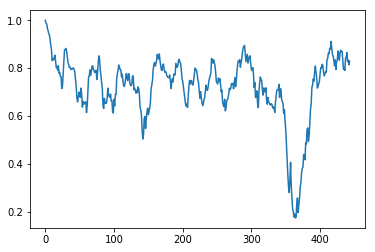

In [20]:
import matplotlib.pyplot as plt
print(len(cluster_word_similarity))
for i in range(0,len(cluster_word_similarity),3000):
    print(i)
    plt.plot(cluster_word_similarity[i])
    plt.show()

# 방법2

In [74]:
term = 30
doc_size = 600

cluster_word = []

cluster_word = [words[i:i+doc_size] for i in  range(0,len(words),term) if i+doc_size < len(words)]
# print("cluster_word[0] : ",cluster_word[0])
print(len(cluster_word))
print(len(words))
cluster_word_vector = []

for words_list in cluster_word:
    sum = np.zeros(vector_size,dtype=float)
    for v in [final_embeddings[dictionary[vector[0]]] for vector in words_list]:
        sum = np.add(sum,v)
    cluster_word_vector.append(sum)

688
21212


In [75]:
from sklearn.metrics.pairwise import cosine_similarity
cluster_word_similarity =  cosine_similarity(cluster_word_vector,cluster_word_vector)
test = [v[i+1:i+2] for i,v in enumerate(cluster_word_similarity)]

(688, 3)
<class 'numpy.ndarray'>


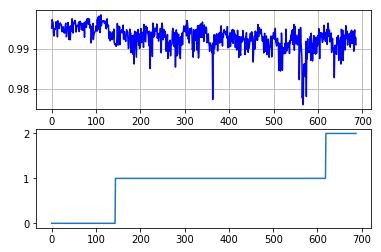

In [76]:
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inlince
words_chart = [words[i] for i in  range(0,len(words),term) if i+doc_size < len(words)]
words_chart = np.array(words_chart)
print(words_chart.shape)
print(type(words_chart[1]))
# print(words_chart[:])
flg = plt.figure()
x1 = flg.add_subplot(2, 1, 1)

x1.plot(test[:-1],color='blue')
x1.grid(True)

x2 = flg.add_subplot(2, 1, 2)
x2.plot(words_chart[:,[2]])
# plt.figure(figsize=(30, 20))
plt.show()

# 군집수 분석

### 인덱스 범위값 보기

In [5]:
def talk_str(talk_list,words_chart,start,end):
    return talk_list[int(words_chart[start][1]):int(words_chart[end][1])],int(words_chart[end][1])-int(words_chart[start][1])

# str , size = talk_str(talk_list,words_chart,140,150)
# print(size)
# print(str)
print(words[:20])

[['교생실습' '0' '0']
 ['가다' '0' '0']
 ['온' '0' '0']
 ['얘기' '0' '0']
 ['해' '0' '0']
 ['드리다' '0' '0']
 ['그렇다' '1' '0']
 ['되게' '2' '0']
 ['궁금하다' '2' '0']
 ['아' '3' '0']
 ['그렇다' '3' '0']
 ['갖다' '3' '0']
 ['저희' '4' '0']
 ['교생' '4' '0']
 ['되게' '4' '0']
 ['많다' '4' '0']
 ['' '5' '0']
 ['인제' '6' '0']
 ['나이' '7' '0']
 ['제일' '7' '0']]


### 클러스터링1

In [72]:
def cluster_boundary1(similarity,repeat,min,cluster_value,term):
    index=[]
    sim = similarity[:]
    #repeat 만큼 반복해서 걸러내기
    for rpt in range(repeat):
        sim.sort()
        # min%만큼 낮은값만 뽑아내는 작업
        index = [similarity.index(i) for i in sim[:int(len(sim)*(min/100))]]
        sim = [similarity[i] for i in index]
    
    index.sort()
    # 가까이있는값은 하나로 묶기 (cluster_value)
    indexing = [v  for i,v in enumerate(index) if (v-index[i-1])/len(similarity) > cluster_value]
#     print(index)
#     print(indexing)
#     print(len(similarity))
    
    #노이즈로 생각되는값 뽑기

    # 노이즈 체크 공식 (suhyuns-sim) 전체길이  * min 퍼센트 ^ repeat 수
    # term 으로 체크시 뒤에 노이즈범위 값안에 들어가는만큼 노이즈 count 증가 이걸 noise_check로 비율 넣기
    noise_check = int(math.sqrt(len(similarity)*pow((min/100),2)))
#     print(noise_check)
#     print(index)
    noise_count = []
    for i in indexing:
        check = 0
        idx = index.index(i)
#         print(idx)
        while(True):
            if idx+check >= len(index)-1 or index[idx+check+1] - index[idx] > term:
                break
            check +=1
        noise_count.append(check/noise_check)
    
    return indexing,noise_count

#0에 가까울수록 클러스터 포인트 1넘으면 100% 아님으로보면될듯

cluster_boundary1(test[:-1],2,40,.04,term)

([145, 186, 354, 424], [0.1, 0.3, 0.5, 0.2])

### 클러스터링2 최대최소 비율

In [73]:
def cluster_boundary2(similarity,repeat,min_rate,cluster_value,term):
    index=[]
    sim = similarity[:]
    #repeat 만큼 반복해서 걸러내기
    for rpt in range(repeat):
        #최대최소 안뽑혀서 일단 이걸로 ';;
#         sim.sort()
        min_value = min(sim)
        max_value = max(sim)
        #  max - (max-min)(1-min_ratio/100)
        compare_rate = max_value - (max_value-min_value)*(1-min_rate/100)
#         print("min :",min_value)
#         print("max :",max_value)
#         print("compare_rate :",compare_rate)
        
        # min%만큼 낮은값만 뽑아내는 작업
        index = [similarity.index(i) for i in sim if i< compare_rate]
        sim = [similarity[i] for i in index]
    
    index.sort()
    # 가까이있는값은 하나로 묶기 (cluster_value)
    indexing = [v  for i,v in enumerate(index) if (v-index[i-1])/len(similarity) > cluster_value or i+1 == len(index)]

    #노이즈로 생각되는값 뽑기
    # 노이즈 체크 공식 (suhyuns-sim) 전체길이  * min 퍼센트 ^ repeat 수
    # term 으로 체크시 뒤에 노이즈범위 값안에 들어가는만큼 노이즈 count 증가 이걸 noise_check로 비율 넣기
    
    noise_check = math.sqrt(len(similarity)*pow((min_rate/100),2))
#     print("noise_check : ",noise_check)
    noise_count = []
#     print("index : ",index)
#     print("indexing :",indexing)
    for i in indexing:
        check = 0
        idx = index.index(i)
#         print(idx)
        while(True):
            if idx+check >= len(index)-1 or index[idx+check+1] - index[idx] > term:
                break
            check +=1
        noise_count.append(check/noise_check)
    
    return indexing,noise_count

#0에 가까울수록 클러스터 포인트 1넘으면 100% 아님으로보면될듯

cluster_boundary2(test[:-1],2,40,.04,term)

([567, 637], [0.0, 0.0])

In [126]:
max([1,2,3])

3